In [1]:
# Example configuration
model_name = 'xgboost'
device = 'cpu'
min_samples_per_class = 5
n_classes = 3
n_frac = 0.01
n_trials_tpe = 10
plot_param_importances = False # can take very long!
timeout_tpe = 60
random_state = 42
n_jobs = -1

In [2]:
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# UTILS

In [3]:
def stratified_sample_df(df, stratify_col, frac, min_samples_per_class, random_state):
    grouped = df.groupby(stratify_col)
    sample = grouped.apply(
        lambda x: x.sample(
            n=max(min_samples_per_class, int(len(x) * frac)), 
            replace=len(x) < max(min_samples_per_class, int(len(x) * frac)),
            random_state=random_state
        )
    ).reset_index(drop=True)
    return sample

In [4]:
def build_classifier(extra_kwargs={}):
    clf = None
    if model_name in ['lgbm', 'lightgbm']:
        import lightgbm as lgb
        kwargs = {
            'device_type': device,
            'n_jobs': n_jobs,
            'objective': 'binary' if n_classes == 2 else 'multiclass',
            'random_state': random_state,
            'verbose': 1,
            **extra_kwargs
        }
        if n_classes > 2:
            kwargs['num_class'] = n_classes
        clf = lgb.LGBMClassifier(**kwargs)
    elif model_name in ['xgb', 'xgboost']:
        from xgboost import XGBClassifier
        kwargs = {
            'device': device,
            'eval_metric': 'logloss' if n_classes == 2 else 'mlogloss',
            'n_jobs': n_jobs,
            'random_state': random_state,
            'tree_method': 'hist',
            **extra_kwargs
        }
        clf = XGBClassifier(**kwargs)
    elif model_name in ['xgbrf', 'xgboostrf']:
        from xgboost import XGBRFClassifier
        kwargs = {
            'device': device,
            'eval_metric': 'logloss' if n_classes == 2 else 'mlogloss',
            'n_jobs': n_jobs,
            'random_state': random_state,
            'tree_method': 'hist',
            **extra_kwargs
        }
        clf = XGBRFClassifier(**kwargs)
    return clf

In [5]:
from collections import OrderedDict
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

def process_metrics(y_test, y_pred):
    
    accuracy = accuracy_score(y_test, y_pred)
    
    precision_macro = precision_score(y_test, y_pred, average='macro', zero_division=0)
    precision_micro = precision_score(y_test, y_pred, average='micro', zero_division=0)
    precision_weighted = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    
    recall_macro = recall_score(y_test, y_pred, average='macro', zero_division=0)
    recall_micro = recall_score(y_test, y_pred, average='micro', zero_division=0)
    recall_weighted = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    
    f1_macro = f1_score(y_test, y_pred, average='macro', zero_division=0)
    f1_micro = f1_score(y_test, y_pred, average='micro', zero_division=0)
    f1_weighted = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    
    results = OrderedDict({
        'Accuracy': accuracy,
        'Precision (Macro)': precision_macro,
        'Precision (Micro)': precision_micro,
        'Precision (Weighted)': precision_weighted,
        'Recall (Macro)': recall_macro,
        'Recall (Micro)': recall_micro,
        'Recall (Weighted)': recall_weighted,
        'F1 (Macro)': f1_macro,
        'F1 (Micro)': f1_micro,
        'F1 (Weighted)': f1_weighted
    })

    pprint(results, indent=4)

In [6]:
from sklearn.metrics import classification_report

def process_classification_report(y_test, y_pred):
    try:
        labels_str = [str(x) for x in labels]
        cr = classification_report(y_test, y_pred, digits=6, target_names=labels_str)
        print(cr)
    except Exception as e:
        print('Cloud not build/show classification report. Reason:', e)

In [7]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def process_confusion_matrix(y_test, y_pred, round_thousand=False):
    try:
        y_test_decoded = [index_to_label[label] for label in y_test]
        y_pred_decoded = [index_to_label[label] for label in y_pred]
        cm = confusion_matrix(y_test_decoded, y_pred_decoded, labels=labels)
        if round_thousand:
            cm = np.round(cm / 1000, 1)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
        disp.plot(values_format='g')
    except Exception as e:
        print('Cloud not build/show confusion matrix. Reason:', e)

In [8]:
import numpy as np

def value_counts_to_dict(array):
    unique, counts = np.unique(array, return_counts=True)
    value_counts_dict = dict(zip(unique, counts))
    return value_counts_dict

# STEP 1: DATA PREP

In [9]:
# %load_ext cudf.pandas
import numpy as np
import pandas as pd
from pprint import pprint

if n_classes == 3: # dummy dataset
    df_sample = pd.read_parquet('input/dummy.parquet')
else:
    df_sample = pd.read_parquet(f'input/CICIoT2023_{n_classes}.parquet')

df_sample['label'], unique_values = df_sample['label'].factorize()

label_to_index = {value: i for i, value in enumerate(unique_values)}
index_to_label = {v: k for k, v in label_to_index.items()}
labels = list(label_to_index.keys())
pprint(label_to_index, indent=4)

{0: 0, 1: 1, 2: 2}


In [10]:
# not stratified df sampling (just to check)
df_sample['label'].sample(frac=n_frac, random_state=random_state).value_counts()

label
0    155
1     79
2     46
Name: count, dtype: int64

In [11]:
# stratified df sampling
df_sample = stratified_sample_df(df_sample, 'label', n_frac, min_samples_per_class, random_state)

C:\Users\marce\AppData\Local\Temp\ipykernel_7012\2006267505.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sample = grouped.apply(


In [12]:
df_sample['label'].value_counts()

label
0    160
1     80
2     40
Name: count, dtype: int64

In [13]:
X_sample = df_sample.drop('label', axis=1)

print(type(X_sample))
print(X_sample.shape)
print(X_sample.dtypes)

<class 'pandas.core.frame.DataFrame'>
(280, 10)
x0    float64
x1    float64
x2    float64
x3    float64
x4    float64
x5    float64
x6    float64
x7    float64
x8    float64
x9    float64
dtype: object


In [14]:
y_sample = df_sample['label']

print(type(y_sample))
print(y_sample.shape)
print(y_sample.dtype)
print(y_sample.unique())
print(y_sample.nunique())
y_sample.value_counts()

<class 'pandas.core.series.Series'>
(280,)
int64
[0 1 2]
3


label
0    160
1     80
2     40
Name: count, dtype: int64

In [15]:
from sklearn.model_selection import train_test_split

# Split into 80% training+validation and 20% test
X_sample_train_val, X_sample_test, y_sample_train_val, y_sample_test = train_test_split(
    X_sample, y_sample, test_size=0.2, random_state=random_state, stratify=y_sample
)

# Split the 80% training+validation set into 75% training and 25% validation
X_sample_train, X_sample_val, y_sample_train, y_sample_val = train_test_split(
    X_sample_train_val, y_sample_train_val, test_size=0.25, random_state=random_state, stratify=y_sample_train_val
)

# Verify the sizes of the splits
print(f'Training   : {len(X_sample_train)}\t({(100.0 * len(X_sample_train) / len(X_sample)):.2f}) %\t{sorted(y_sample_train.unique())}')
print(f'Validation : {len(X_sample_val)}\t({(100.0 * len(X_sample_val) / len(X_sample)):.2f}) %\t{sorted(y_sample_val.unique())}')
print(f'Test       : {len(X_sample_test)}\t({(100.0 * len(X_sample_test) / len(X_sample)):.2f}) %\t{sorted(y_sample_test.unique())}')

Training   : 168	(60.00) %	[np.int64(0), np.int64(1), np.int64(2)]
Validation : 56	(20.00) %	[np.int64(0), np.int64(1), np.int64(2)]
Test       : 56	(20.00) %	[np.int64(0), np.int64(1), np.int64(2)]


In [16]:
assert sorted(y_sample_train.unique()) == sorted(y_sample_val.unique())
assert sorted(y_sample_train.unique()) == sorted(y_sample_test.unique())
assert sorted(y_sample_val.unique()) == sorted(y_sample_test.unique())

# STEP 2: PREPROCESSING & FEATURE SELECTION

### Preprocessing Methods

In [17]:
from sklearn.preprocessing import MaxAbsScaler, MinMaxScaler, Normalizer, RobustScaler, StandardScaler

class DummyPreprocessor:
    def fit(self, _X, _y=None):
        return self
    def transform(self, _X):
        return _X

def make_preprocessor(pp_method):
    preprocessor = None
    if pp_method == 'none':
        preprocessor = DummyPreprocessor()
    if pp_method == 'maxabs':
        preprocessor = MaxAbsScaler()
    elif pp_method == 'minmax':
        preprocessor = MinMaxScaler()
    elif pp_method == 'norm':
        preprocessor = Normalizer()
    elif pp_method == 'robust':
        preprocessor = RobustScaler()
    elif pp_method == 'standard':
        preprocessor = StandardScaler()
    return preprocessor

### Feature Selection Methods

In [18]:
from shaphypetune import BoostSearch, BoostBoruta, BoostRFE, BoostRFA

class DummyFeatureSelector:
    def fit(self, _X, _y, _eval_set=None):
        self.support_ = np.ones(_X.shape[1], dtype=bool)
        return self
    def transform(self, _X):
        return _X[:, self.support_]

def make_feature_selector(fs_method, fs_metric):
    feature_selector = None
    if fs_method == 'none':
        feature_selector = DummyFeatureSelector()
    elif fs_method == 'boruta':
        feature_selector = BoostBoruta(build_classifier(), importance_type=fs_metric, perc=100, sampling_seed=random_state)
    elif fs_method == 'rfa':
        feature_selector = BoostRFA(build_classifier(), importance_type=fs_metric, min_features_to_select=1, sampling_seed=random_state, step=1)
    elif fs_method == 'rfe':
        feature_selector = BoostRFE(build_classifier(), importance_type=fs_metric, min_features_to_select=1, sampling_seed=random_state, step=1)
    return feature_selector

### HPO

In [19]:
%%time

import optuna

from optuna.samplers import GridSampler

def objective(trial):

    try:
        # preprocessing hyperparameters
        pp_method = trial.suggest_categorical('pp_method', ['none', 'maxabs', 'minmax', 'norm', 'robust', 'standard'])

        # feature selection hyperparameters
        fs_method = trial.suggest_categorical('fs_method', ['none', 'boruta', 'rfa', 'rfe'])
        fs_metric = trial.suggest_categorical('fs_metric', ['feature_importances', 'shap_importances'])
        
        # pipeline - preprocessing
        preprocessor = make_preprocessor(pp_method)
        preprocessor.fit(X_sample_train)
        X_sample_train_prep = pd.DataFrame(preprocessor.transform(X_sample_train.copy()), columns=X_sample_train.columns)
        X_sample_val_prep = pd.DataFrame(preprocessor.transform(X_sample_val.copy()), columns=X_sample_val.columns)
        X_sample_test_prep = pd.DataFrame(preprocessor.transform(X_sample_test.copy()), columns=X_sample_test.columns)
    
        # pipeline - feature selection
        feature_selector = make_feature_selector(fs_method, fs_metric)
        feature_selector.fit(X_sample_train_prep, y_sample_train, eval_set=[(X_sample_val_prep, y_sample_val)])
        selected_features = X_sample_train_prep.columns[feature_selector.support_]
        trial.set_user_attr('selected_features', selected_features)
        
        # pipeline - classifier fit/predict
        model = build_classifier()
        model.fit(X_sample_train_prep[selected_features], y_sample_train)
        y_sample_pred = model.predict(X_sample_test_prep[selected_features])
    
        return f1_score(y_sample_test, y_sample_pred, average='macro', zero_division=0)
        
    except Exception as e:
        print(e)
        raise optuna.TrialPruned()

# Perform HPO with a Grid sampler
search_space = {
    'pp_method': ['none', 'maxabs', 'minmax', 'norm', 'robust', 'standard'],
    'fs_method': ['boruta', 'rfa', 'rfe'],
    'fs_metric': ['feature_importances', 'shap_importances']
}
sampler = GridSampler(search_space)
n_trials_grid = np.prod([len(v) for v in search_space.values()])
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=n_trials_grid)

[I 2025-02-28 01:26:58,717] A new study created in memory with name: no-name-187ea6b7-2a2f-4ba6-b139-5757a06761ff
[I 2025-02-28 01:26:59,754] Trial 0 finished with value: 0.76007326007326 and parameters: {'pp_method': 'robust', 'fs_method': 'rfe', 'fs_metric': 'feature_importances'}. Best is trial 0 with value: 0.76007326007326.
[I 2025-02-28 01:27:00,542] Trial 1 finished with value: 0.8125 and parameters: {'pp_method': 'maxabs', 'fs_method': 'rfa', 'fs_metric': 'shap_importances'}. Best is trial 1 with value: 0.8125.
[I 2025-02-28 01:27:01,511] Trial 2 finished with value: 0.7089912280701754 and parameters: {'pp_method': 'norm', 'fs_method': 'rfe', 'fs_metric': 'feature_importances'}. Best is trial 1 with value: 0.8125.
[I 2025-02-28 01:27:02,490] Trial 3 finished with value: 0.76007326007326 and parameters: {'pp_method': 'minmax', 'fs_method': 'rfe', 'fs_metric': 'feature_importances'}. Best is trial 1 with value: 0.8125.
[I 2025-02-28 01:27:03,224] Trial 4 finished with value: 0.64

shape mismatch: value array of shape (10,3) could not be broadcast to indexing result of shape (10,)


[I 2025-02-28 01:27:06,804] Trial 8 finished with value: 0.76007326007326 and parameters: {'pp_method': 'none', 'fs_method': 'rfa', 'fs_metric': 'feature_importances'}. Best is trial 1 with value: 0.8125.
[I 2025-02-28 01:27:07,800] Trial 9 finished with value: 0.76007326007326 and parameters: {'pp_method': 'maxabs', 'fs_method': 'rfe', 'fs_metric': 'feature_importances'}. Best is trial 1 with value: 0.8125.
[I 2025-02-28 01:27:13,558] Trial 10 finished with value: 0.7089912280701754 and parameters: {'pp_method': 'norm', 'fs_method': 'boruta', 'fs_metric': 'feature_importances'}. Best is trial 1 with value: 0.8125.
[I 2025-02-28 01:27:14,305] Trial 11 finished with value: 0.8125 and parameters: {'pp_method': 'none', 'fs_method': 'rfa', 'fs_metric': 'shap_importances'}. Best is trial 1 with value: 0.8125.
[I 2025-02-28 01:27:14,899] Trial 12 finished with value: 0.7248677248677248 and parameters: {'pp_method': 'robust', 'fs_method': 'rfe', 'fs_metric': 'shap_importances'}. Best is trial

shape mismatch: value array of shape (10,3) could not be broadcast to indexing result of shape (10,)
shape mismatch: value array of shape (10,3) could not be broadcast to indexing result of shape (10,)


[I 2025-02-28 01:27:16,965] Trial 15 finished with value: 0.76007326007326 and parameters: {'pp_method': 'minmax', 'fs_method': 'rfa', 'fs_metric': 'feature_importances'}. Best is trial 1 with value: 0.8125.
[I 2025-02-28 01:27:18,678] Trial 16 finished with value: 0.76007326007326 and parameters: {'pp_method': 'standard', 'fs_method': 'rfa', 'fs_metric': 'feature_importances'}. Best is trial 1 with value: 0.8125.
[I 2025-02-28 01:27:19,260] Trial 17 finished with value: 0.7248677248677248 and parameters: {'pp_method': 'standard', 'fs_method': 'rfe', 'fs_metric': 'shap_importances'}. Best is trial 1 with value: 0.8125.
[I 2025-02-28 01:27:19,842] Trial 18 finished with value: 0.7089912280701754 and parameters: {'pp_method': 'norm', 'fs_method': 'rfe', 'fs_metric': 'shap_importances'}. Best is trial 1 with value: 0.8125.
[I 2025-02-28 01:27:20,426] Trial 19 finished with value: 0.7248677248677248 and parameters: {'pp_method': 'none', 'fs_method': 'rfe', 'fs_metric': 'shap_importances'}.

shape mismatch: value array of shape (10,3) could not be broadcast to indexing result of shape (10,)


[I 2025-02-28 01:27:28,455] Trial 24 finished with value: 0.76007326007326 and parameters: {'pp_method': 'robust', 'fs_method': 'boruta', 'fs_metric': 'feature_importances'}. Best is trial 1 with value: 0.8125.
[I 2025-02-28 01:27:30,188] Trial 25 finished with value: 0.76007326007326 and parameters: {'pp_method': 'maxabs', 'fs_method': 'rfa', 'fs_metric': 'feature_importances'}. Best is trial 1 with value: 0.8125.
[I 2025-02-28 01:27:30,880] Trial 26 finished with value: 0.7248677248677248 and parameters: {'pp_method': 'maxabs', 'fs_method': 'rfe', 'fs_metric': 'shap_importances'}. Best is trial 1 with value: 0.8125.
[I 2025-02-28 01:27:31,611] Trial 27 finished with value: 0.8125 and parameters: {'pp_method': 'minmax', 'fs_method': 'rfa', 'fs_metric': 'shap_importances'}. Best is trial 1 with value: 0.8125.
[I 2025-02-28 01:27:34,606] Trial 28 finished with value: 0.76007326007326 and parameters: {'pp_method': 'maxabs', 'fs_method': 'boruta', 'fs_metric': 'feature_importances'}. Best

shape mismatch: value array of shape (10,3) could not be broadcast to indexing result of shape (10,)


[I 2025-02-28 01:27:43,172] Trial 33 finished with value: 0.8125 and parameters: {'pp_method': 'standard', 'fs_method': 'rfa', 'fs_metric': 'shap_importances'}. Best is trial 1 with value: 0.8125.
[I 2025-02-28 01:27:43,349] Trial 34 pruned. 


shape mismatch: value array of shape (10,3) could not be broadcast to indexing result of shape (10,)


[I 2025-02-28 01:27:45,076] Trial 35 finished with value: 0.76007326007326 and parameters: {'pp_method': 'robust', 'fs_method': 'rfa', 'fs_metric': 'feature_importances'}. Best is trial 1 with value: 0.8125.


CPU times: total: 13min 36s
Wall time: 46.4 s


In [20]:
study.trials_dataframe()

number     value             datetime_start          datetime_complete  \
0        0  0.760073 2025-02-28 01:26:58.718266 2025-02-28 01:26:59.754606   
1        1  0.812500 2025-02-28 01:26:59.755610 2025-02-28 01:27:00.542111   
2        2  0.708991 2025-02-28 01:27:00.543109 2025-02-28 01:27:01.511056   
3        3  0.760073 2025-02-28 01:27:01.512557 2025-02-28 01:27:02.490503   
4        4  0.642984 2025-02-28 01:27:02.491503 2025-02-28 01:27:03.224373   
5        5  0.724868 2025-02-28 01:27:03.225376 2025-02-28 01:27:03.887018   
6        6  0.760073 2025-02-28 01:27:03.888018 2025-02-28 01:27:04.855791   
7        7       NaN 2025-02-28 01:27:04.856794 2025-02-28 01:27:05.018618   
8        8  0.760073 2025-02-28 01:27:05.019618 2025-02-28 01:27:06.804405   
9        9  0.760073 2025-02-28 01:27:06.805913 2025-02-28 01:27:07.800648   
10      10  0.708991 2025-02-28 01:27:07.801651 2025-02-28 01:27:13.558147   
11      11  0.812500 2025-02-28 01:27:13.559145 2025-02-28 01:27:14.305344   
12      12  0.724868 2025-02-28 01:27:14.306349 2025-02-28 01:27:14.899450   
13      13       NaN 2025-02-28 01:27:14.900451 2025-02-28 01:27:15.066810   
14      14       NaN 2025-02-28 01:27:15.067809 2025-02-28 01:27:15.229576   
15      15  0.760073 2025-02-28 01:27:15.230078 2025-02-28 01:27:16.965474   
16      16  0.760073 2025-02-28 01:27:16.966478 2025-02-28 01:27:18.678934   
17      17  0.724868 2025-02-28 01:27:18.679934 2025-02-28 01:27:19.259921   
18      18  0.708991 2025-02-28 01:27:19.260922 2025-02-28 01:27:19.842148   
19      19  0.724868 2025-02-28 01:27:19.843149 2025-02-28 01:27:20.426277   
20      20  0.760073 2025-02-28 01:27:20.427281 2025-02-28 01:27:23.422572   
21      21  0.812500 2025-02-28 01:27:23.423072 2025-02-28 01:27:24.172379   
22      22  0.760073 2025-02-28 01:27:24.173380 2025-02-28 01:27:25.168385   
23      23       NaN 2025-02-28 01:27:25.169386 2025-02-28 01:27:25.327198   
24      24  0.760073 2025-02-28 01:27:25.328196 2025-02-28 01:27:28.455788   
25      25  0.760073 2025-02-28 01:27:28.456787 2025-02-28 01:27:30.188731   
26      26  0.724868 2025-02-28 01:27:30.189733 2025-02-28 01:27:30.880407   
27      27  0.812500 2025-02-28 01:27:30.881407 2025-02-28 01:27:31.611139   
28      28  0.760073 2025-02-28 01:27:31.612139 2025-02-28 01:27:34.606545   
29      29  0.760073 2025-02-28 01:27:34.607544 2025-02-28 01:27:37.574195   
30      30  0.642984 2025-02-28 01:27:37.574695 2025-02-28 01:27:39.291224   
31      31  0.760073 2025-02-28 01:27:39.292224 2025-02-28 01:27:42.228835   
32      32       NaN 2025-02-28 01:27:42.229836 2025-02-28 01:27:42.391635   
33      33  0.812500 2025-02-28 01:27:42.392634 2025-02-28 01:27:43.172146   
34      34       NaN 2025-02-28 01:27:43.173143 2025-02-28 01:27:43.349327   
35      35  0.760073 2025-02-28 01:27:43.350327 2025-02-28 01:27:45.076771   

                 duration params_fs_method     params_fs_metric  \
0  0 days 00:00:01.036340              rfe  feature_importances   
1  0 days 00:00:00.786501              rfa     shap_importances   
2  0 days 00:00:00.967947              rfe  feature_importances   
3  0 days 00:00:00.977946              rfe  feature_importances   
4  0 days 00:00:00.732870              rfa     shap_importances   
5  0 days 00:00:00.661642              rfe     shap_importances   
6  0 days 00:00:00.967773              rfe  feature_importances   
7  0 days 00:00:00.161824           boruta     shap_importances   
8  0 days 00:00:01.784787              rfa  feature_importances   
9  0 days 00:00:00.994735              rfe  feature_importances   
10 0 days 00:00:05.756496           boruta  feature_importances   
11 0 days 00:00:00.746199              rfa     shap_importances   
12 0 days 00:00:00.593101              rfe     shap_importances   
13 0 days 00:00:00.166359           boruta     shap_importances   
14 0 days 00:00:00.161767           boruta     shap_importances   
15 0 days 00:00:01.735396              rfa  f

In [21]:
fig = optuna.visualization.plot_optimization_history(study)
fig.update_layout(width=800, height=600)
fig.show()

In [22]:
fig = optuna.visualization.plot_parallel_coordinate(study)
fig.update_layout(width=800, height=600)
fig.show()

In [23]:
if plot_param_importances:
    fig = optuna.visualization.plot_param_importances(study)
    fig.update_layout(width=800, height=600)
    fig.show()

In [24]:
fig = optuna.visualization.plot_contour(study)
fig.update_layout(width=800, height=600)
fig.show()

In [25]:
best_preprocessor = make_preprocessor(study.best_trial.params['pp_method'])
best_preprocessor.fit(X_sample_train)
X_sample_train = pd.DataFrame(best_preprocessor.transform(X_sample_train.copy()), columns=X_sample_train.columns)
X_sample_val = pd.DataFrame(best_preprocessor.transform(X_sample_val.copy()), columns=X_sample_val.columns)
X_sample_test = pd.DataFrame(best_preprocessor.transform(X_sample_test.copy()), columns=X_sample_test.columns)

best_selected_features = study.best_trial.user_attrs['selected_features']
X_sample_train = X_sample_train[best_selected_features]
X_sample_val = X_sample_val[best_selected_features]
X_sample_test = X_sample_test[best_selected_features]

# STEP 3: DATA BALANCING

### Oversampling

In [26]:
# from cuml.neighbors import KNeighborsClassifier
# from cuml.neighbors import NearestNeighbors
from imblearn.over_sampling import *

def build_oversampling_strategy(value_counts, threshold):
    n_occurences = sum([n for n in value_counts.values()])
    perfectly_balanced_occurences = int(n_occurences / len(value_counts.keys()))
    if threshold == "auto":
        n_generate = {
            class_: perfectly_balanced_occurences - occ
                    if occ < perfectly_balanced_occurences else 0
                    for class_, occ in value_counts.items()
        }
    else:
        n_generate = {
            class_: int(min(occ * threshold, perfectly_balanced_occurences - occ))
            if occ < perfectly_balanced_occurences else 0
            for class_, occ in value_counts.items()
        }
    return n_generate

def patch_oversampling_strategy(value_counts, n_generate):
    return {k : (value_counts[k] + n_generate[k]) for k in value_counts.keys()}

def make_over_sampler(over_strategy):
    over_sampler = RandomOverSampler(
        random_state=random_state, sampling_strategy=over_strategy)
    return over_sampler

### Undersampling

In [27]:
# from cuml.neighbors import KNeighborsClassifier
# from cuml.neighbors import NearestNeighbors
from imblearn.under_sampling import *

def build_undersampling_strategy(value_counts, threshold):
    n_occurences = sum([n for n in value_counts.values()])
    perfectly_balanced_occurences = int(n_occurences / len(value_counts.keys()))
    if threshold == "auto":
        n_remove = {
            class_: occ - perfectly_balanced_occurences
                    if occ > perfectly_balanced_occurences else 0
                    for class_, occ in value_counts.items()
        }
    else:
        n_remove = {
            class_: int(min(occ * threshold, occ - perfectly_balanced_occurences))
            if occ > perfectly_balanced_occurences else 0
            for class_, occ in value_counts.items()
        }
    return n_remove

def patch_undersampling_strategy(value_counts, n_remove):
    return {k : (value_counts[k] - n_remove[k]) for k in value_counts.keys()}

def make_under_sampler(under_strategy):
    under_sampler = RandomUnderSampler(
        random_state=random_state, sampling_strategy=under_strategy)
    return under_sampler

### Combination

In [28]:
def fit_resample(_X_train, _y_train, over_thresh, under_thresh):

    _X_names = _X_train.columns.tolist()
    _y_name = _y_train.name
    
    _X_train_copy = _X_train.copy()
    _y_train_copy = _y_train.copy()

    if over_thresh:
        value_counts = value_counts_to_dict(_y_train_copy)
        n_generate = build_oversampling_strategy(value_counts, over_thresh)
        over_strategy = patch_oversampling_strategy(value_counts, n_generate)
        over_sampler = make_over_sampler(over_strategy)
        _X_train_copy, _y_train_copy = over_sampler.fit_resample(_X_train_copy, _y_train_copy)

    if under_thresh:
        value_counts = value_counts_to_dict(_y_train_copy)
        n_remove = build_undersampling_strategy(value_counts, under_thresh)
        under_strategy = patch_undersampling_strategy(value_counts, n_remove)
        under_sampler = make_under_sampler(under_strategy)
        _X_train_copy, _y_train_copy = under_sampler.fit_resample(_X_train_copy, _y_train_copy)

    return pd.DataFrame(_X_train_copy, columns=_X_names), pd.Series(_y_train_copy, name=_y_name)

### HPO

In [29]:
from itertools import chain

over_threshold_choices = list(chain(*[np.linspace(0, 4, num=17).round(2), ['auto']]))
under_threshold_choices = list(chain(*[np.linspace(0, 0.95, num=20).round(2), ['auto']]))

In [30]:
%%time
def objective(trial):

    try:
        # data balancing hyperparameters
        over_threshold = trial.suggest_categorical('over_threshold', over_threshold_choices)
        under_threshold = trial.suggest_categorical('under_threshold', under_threshold_choices)
    
        # pipeline - data balancing
        X_sample_train_bal, y_sample_train_bal = fit_resample(
            X_sample_train, y_sample_train, over_threshold, under_threshold
        )
        
        # pipeline - classifier fit/predict
        model = build_classifier()
        model.fit(X_sample_train_bal, y_sample_train_bal)
        y_sample_pred = model.predict(X_sample_test)
    
        return f1_score(y_sample_test, y_sample_pred, average='macro', zero_division=0)

    except Exception as e:
        print(e)
        raise optuna.TrialPruned()

# Perform HPO with a Grid sampler
search_space = {
    'over_threshold': over_threshold_choices,
    'under_threshold': under_threshold_choices
}
sampler = GridSampler(search_space)
n_trials_grid = np.prod([len(v) for v in search_space.values()])
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=n_trials_grid)

[I 2025-02-28 01:27:45,642] A new study created in memory with name: no-name-606eb631-9422-4e13-9c4d-3cc4f24caf47
[I 2025-02-28 01:27:45,721] Trial 0 finished with value: 0.7835969233428397 and parameters: {'over_threshold': np.float64(2.75), 'under_threshold': np.float64(0.65)}. Best is trial 0 with value: 0.7835969233428397.
[I 2025-02-28 01:27:45,899] Trial 1 finished with value: 0.8888888888888888 and parameters: {'over_threshold': np.float64(2.0), 'under_threshold': np.float64(0.15)}. Best is trial 1 with value: 0.8888888888888888.
[I 2025-02-28 01:27:45,979] Trial 2 finished with value: 0.7835969233428397 and parameters: {'over_threshold': np.float64(3.0), 'under_threshold': 'auto'}. Best is trial 1 with value: 0.8888888888888888.
[I 2025-02-28 01:27:46,064] Trial 3 finished with value: 0.8210084033613446 and parameters: {'over_threshold': np.float64(1.25), 'under_threshold': np.float64(0.2)}. Best is trial 1 with value: 0.8888888888888888.
[I 2025-02-28 01:27:46,145] Trial 4 fin

CPU times: total: 11min 51s
Wall time: 40.3 s


In [31]:
study.trials_dataframe()

number     value             datetime_start          datetime_complete  \
0         0  0.783597 2025-02-28 01:27:45.643663 2025-02-28 01:27:45.721265   
1         1  0.888889 2025-02-28 01:27:45.722265 2025-02-28 01:27:45.898547   
2         2  0.783597 2025-02-28 01:27:45.899548 2025-02-28 01:27:45.979153   
3         3  0.821008 2025-02-28 01:27:45.980151 2025-02-28 01:27:46.064335   
4         4  0.743815 2025-02-28 01:27:46.065841 2025-02-28 01:27:46.145446   
..      ...       ...                        ...                        ...   
373     373  0.821008 2025-02-28 01:28:25.282609 2025-02-28 01:28:25.401258   
374     374  0.838612 2025-02-28 01:28:25.402766 2025-02-28 01:28:25.526976   
375     375  0.801722 2025-02-28 01:28:25.527479 2025-02-28 01:28:25.652220   
376     376  0.761563 2025-02-28 01:28:25.652718 2025-02-28 01:28:25.782451   
377     377  0.767288 2025-02-28 01:28:25.783450 2025-02-28 01:28:25.917695   

                  duration params_over_threshold params_under_threshold  \
0   0 days 00:00:00.077602                  2.75                   0.65   
1   0 days 00:00:00.176282                   2.0                   0.15   
2   0 days 00:00:00.079605                   3.0                   auto   
3   0 days 00:00:00.084184                  1.25                    0.2   
4   0 days 00:00:00.079605                   0.5                   0.25   
..                     ...                   ...                    ...   
373 0 days 00:00:00.118649                   0.5                    0.3   
374 0 days 00:00:00.124210                   4.0                   0.05   
375 0 days 00:00:00.124741                   1.0                   0.75   
376 0 days 00:00:00.129733                  0.25                    0.4   
377 0 days 00:00:00.134245                   0.5                   0.05   

     system_attrs_grid_id                          system_attrs_search_space  \
0                       0  {'over_threshold': [0.0, 0.25, 0.5, 0.75, 1.0,...   
1                       1  {'over_threshold': [0.0, 0.25, 0.5, 0.75, 1.0,...   
2                       2  {'over_threshold': [0.0, 0.25, 0.5, 0.75, 1.0,...   
3                       3  {'over_threshold': [0.0, 0.25, 0.5, 0.75, 1.0,...   
4                       4  {'over_threshold': [0.0, 0.25, 0.5, 0.75, 1.0,...   
..                    ...                                                ...   
373                   373  {'over_threshold': [0.0, 0.25, 0.5, 0.75, 1.0,...   
374                   374  {'over_threshold': [0.0, 0.25, 0.5, 0.75, 1.0,...   
375                   375  {'over_threshold': [0.0, 0.25, 0.5, 0.75, 1.0,...   
376                   376  {'over_threshold': [0.0, 0.25, 0.5, 0.75, 1.0,...   
377                   377  {'over_threshold': [0.0, 0.25, 0.5, 0.75, 1.0,...   

        state  
0    COMPLETE  
1    COMPLETE  
2    COMPLETE  
3    COMPLETE  
4    COMPLETE  
..        ...  
373  COMPLETE  
374  COMPLETE  
375  COMPLETE  
376  COMPLETE  
377  COMPLETE  

[378 rows x 10 columns]

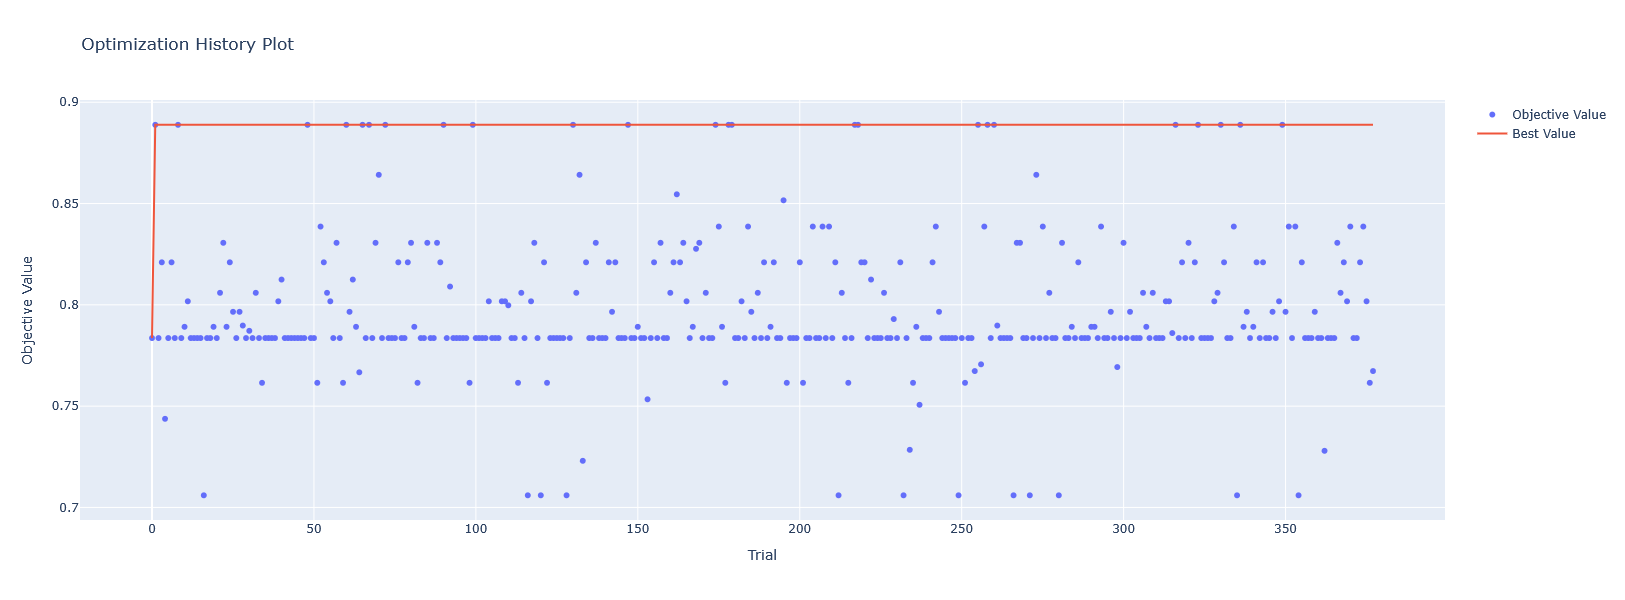

In [32]:
fig = optuna.visualization.plot_optimization_history(study)
fig.update_layout(width=800, height=600)
fig.show()

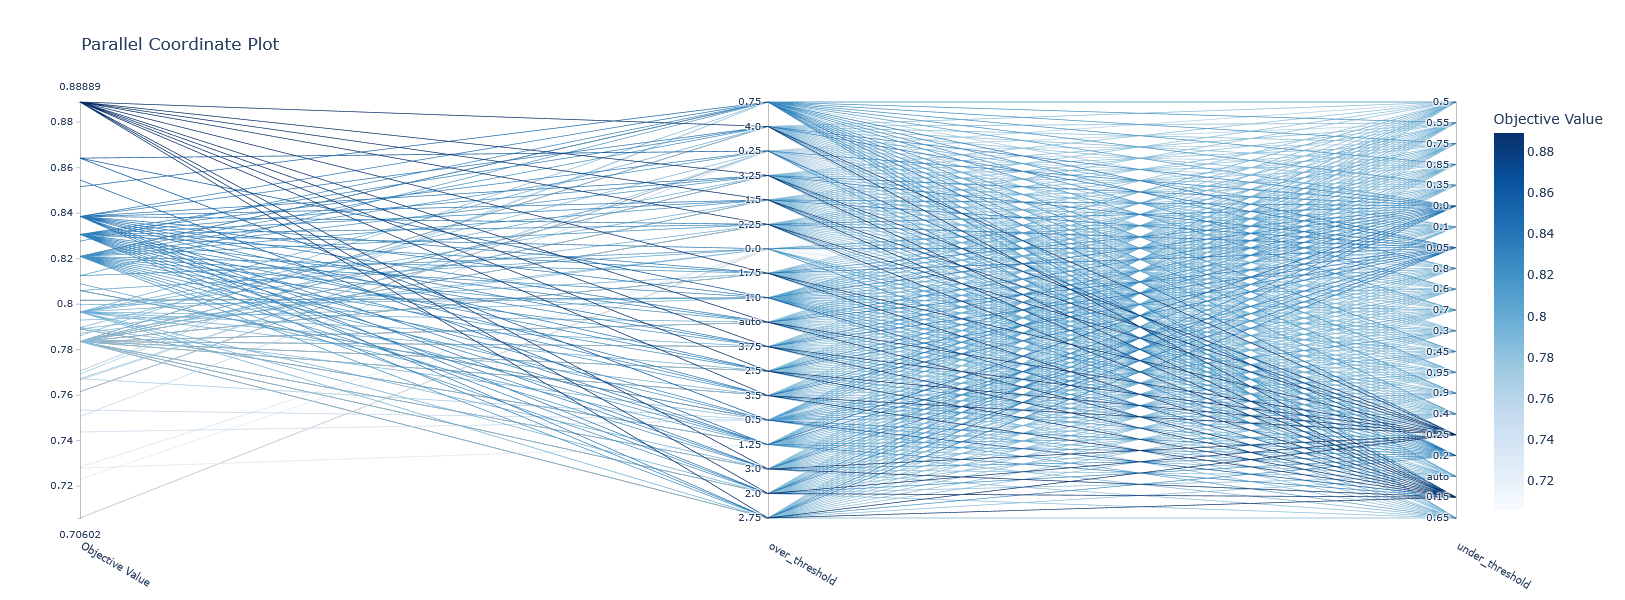

In [33]:
fig = optuna.visualization.plot_parallel_coordinate(study)
fig.update_layout(width=800, height=600)
fig.show()

In [34]:
if plot_param_importances:
    fig = optuna.visualization.plot_param_importances(study)
    fig.update_layout(width=800, height=600)
    fig.show()

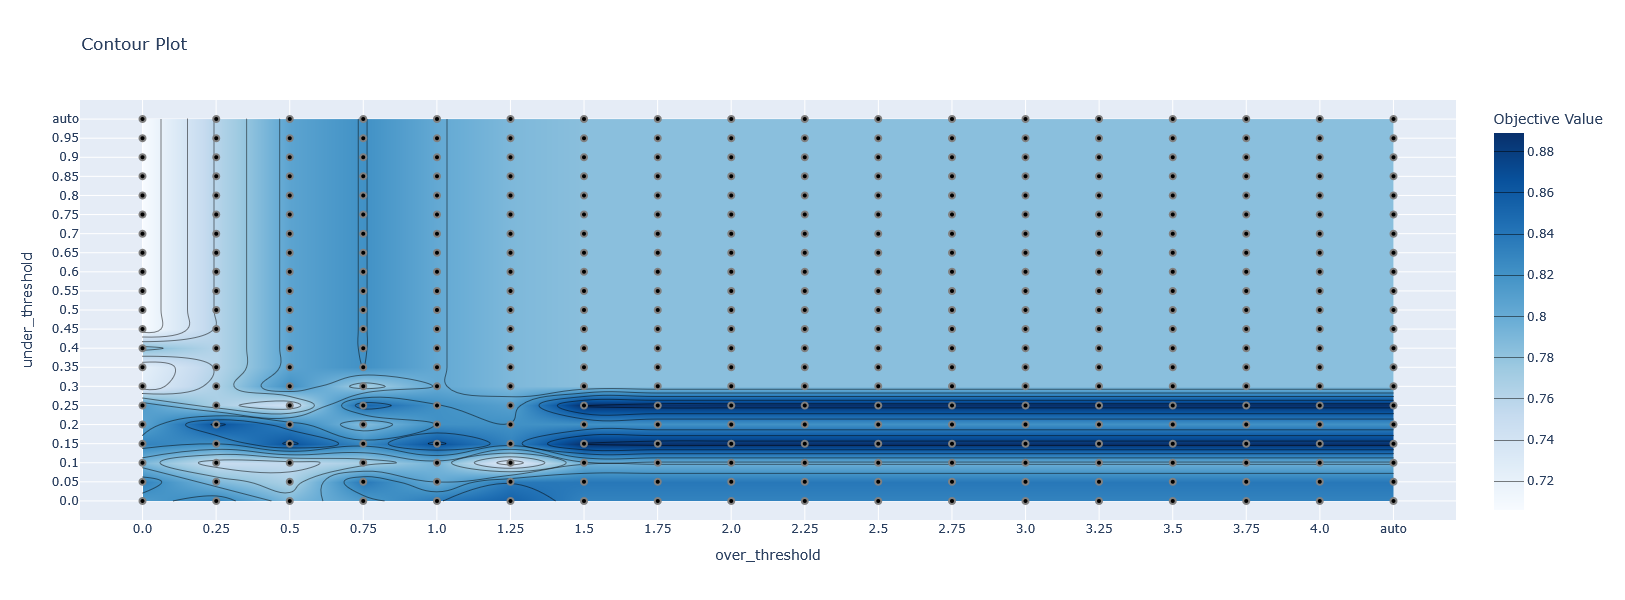

In [35]:
fig = optuna.visualization.plot_contour(study)
fig.update_layout(width=800, height=600)
fig.show()

In [36]:
best_over_threshold = study.best_trial.params['over_threshold']
best_under_threshold = study.best_trial.params['under_threshold']

X_sample_train, y_sample_train = fit_resample(
    X_sample_train, y_sample_train, best_over_threshold, best_under_threshold
)

# STEP 4: CLASSIFICATION

In [37]:
%%time
from optuna.samplers import TPESampler

# Configure HPO objetive function
def objective(trial):

    try:
        # pipeline - classifier hyperparameters
        if model_name in ['lgbm', 'lightgbm', 'xgb', 'xgboost']:
            hpo_kwargs = {
                'n_estimators': trial.suggest_int('n_estimators', 10, 200),
                'max_depth': trial.suggest_int('max_depth', 2, 20),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
                'subsample': trial.suggest_float('subsample', 0.5, 1.0),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0)
            }
        elif model_name in ['xgbrf', 'xgboostrf']:
            hpo_kwargs = {
                'n_estimators': trial.suggest_int('n_estimators', 10, 200),
                'max_depth': trial.suggest_int('max_depth', 2, 20),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
                'subsample': trial.suggest_float('subsample', 0.5, 1.0),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
                'reg_alpha': trial.suggest_float('reg_alpha', 0, 1.0),
                'reg_lambda': trial.suggest_float('reg_lambda', 0, 1.0)
        }

        # pipeline - classifier fit/predict
        model = build_classifier(hpo_kwargs)
        model.fit(X_sample_train, y_sample_train)
        y_sample_pred = model.predict(X_sample_test)
    
        return f1_score(y_sample_test, y_sample_pred, average='macro', zero_division=0)
        
    except Exception as e:
        print(e)
        raise optuna.TrialPruned()

# Perform HPO with a TPE sampler
sampler = TPESampler()
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=n_trials_tpe, timeout=timeout_tpe)

[I 2025-02-28 01:28:26,038] A new study created in memory with name: no-name-9466892a-8279-4b4d-b6b5-0c484c2315f0
[I 2025-02-28 01:28:26,168] Trial 0 finished with value: 0.8306878306878307 and parameters: {'n_estimators': 186, 'max_depth': 10, 'learning_rate': 0.2258711252736134, 'subsample': 0.9511123002410959, 'colsample_bytree': 0.9319208853327959}. Best is trial 0 with value: 0.8306878306878307.
[I 2025-02-28 01:28:26,304] Trial 1 finished with value: 0.8090117767537123 and parameters: {'n_estimators': 196, 'max_depth': 7, 'learning_rate': 0.2438042716750508, 'subsample': 0.7486299026687546, 'colsample_bytree': 0.7585647480353519}. Best is trial 0 with value: 0.8306878306878307.
[I 2025-02-28 01:28:26,458] Trial 2 finished with value: 0.8210084033613446 and parameters: {'n_estimators': 152, 'max_depth': 11, 'learning_rate': 0.10118121531741744, 'subsample': 0.9082680400425258, 'colsample_bytree': 0.8911067439306011}. Best is trial 0 with value: 0.8306878306878307.
[I 2025-02-28 01

CPU times: total: 18.2 s
Wall time: 1.15 s


In [38]:
study.trials_dataframe()

number     value             datetime_start          datetime_complete  \
0       0  0.830688 2025-02-28 01:28:26.039693 2025-02-28 01:28:26.167872   
1       1  0.809012 2025-02-28 01:28:26.168870 2025-02-28 01:28:26.304617   
2       2  0.821008 2025-02-28 01:28:26.305621 2025-02-28 01:28:26.458347   
3       3  0.753815 2025-02-28 01:28:26.458845 2025-02-28 01:28:26.578055   
4       4  0.750638 2025-02-28 01:28:26.579054 2025-02-28 01:28:26.691213   
5       5  0.816340 2025-02-28 01:28:26.692214 2025-02-28 01:28:26.793856   
6       6  0.753815 2025-02-28 01:28:26.794356 2025-02-28 01:28:26.852445   
7       7  0.809012 2025-02-28 01:28:26.852943 2025-02-28 01:28:26.958096   
8       8  0.786111 2025-02-28 01:28:26.959095 2025-02-28 01:28:27.042299   
9       9  0.789130 2025-02-28 01:28:27.043298 2025-02-28 01:28:27.186546   

                duration  params_colsample_bytree  params_learning_rate  \
0 0 days 00:00:00.128179                 0.931921              0.225871   
1 0 days 00:00:00.135747                 0.758565              0.243804   
2 0 days 00:00:00.152726                 0.891107              0.101181   
3 0 days 00:00:00.119210                 0.844833              0.256036   
4 0 days 00:00:00.112159                 0.630130              0.147887   
5 0 days 00:00:00.101642                 0.904687              0.030235   
6 0 days 00:00:00.058089                 0.550015              0.216987   
7 0 days 00:00:00.105153                 0.949466              0.066184   
8 0 days 00:00:00.083204                 0.866147              0.170886   
9 0 days 00:00:00.143248                 0.558516              0.058597   

   params_max_depth  params_n_estimators  params_subsample     state  
0                10                  186          0.951112  COMPLETE  
1                 7                  196          0.748630  COMPLETE  
2                11                  152          0.908268  COMPLETE  
3                17                  169          0.559381  COMPLETE  
4                 8                  115          0.810248  COMPLETE  
5                 3                  147          0.839375  COMPLETE  
6                 6                   57          0.697413  COMPLETE  
7                 6                   97          0.627361  COMPLETE  
8                13                   65          0.819836  COMPLETE  
9                10                  142          0.536434  COMPLETE

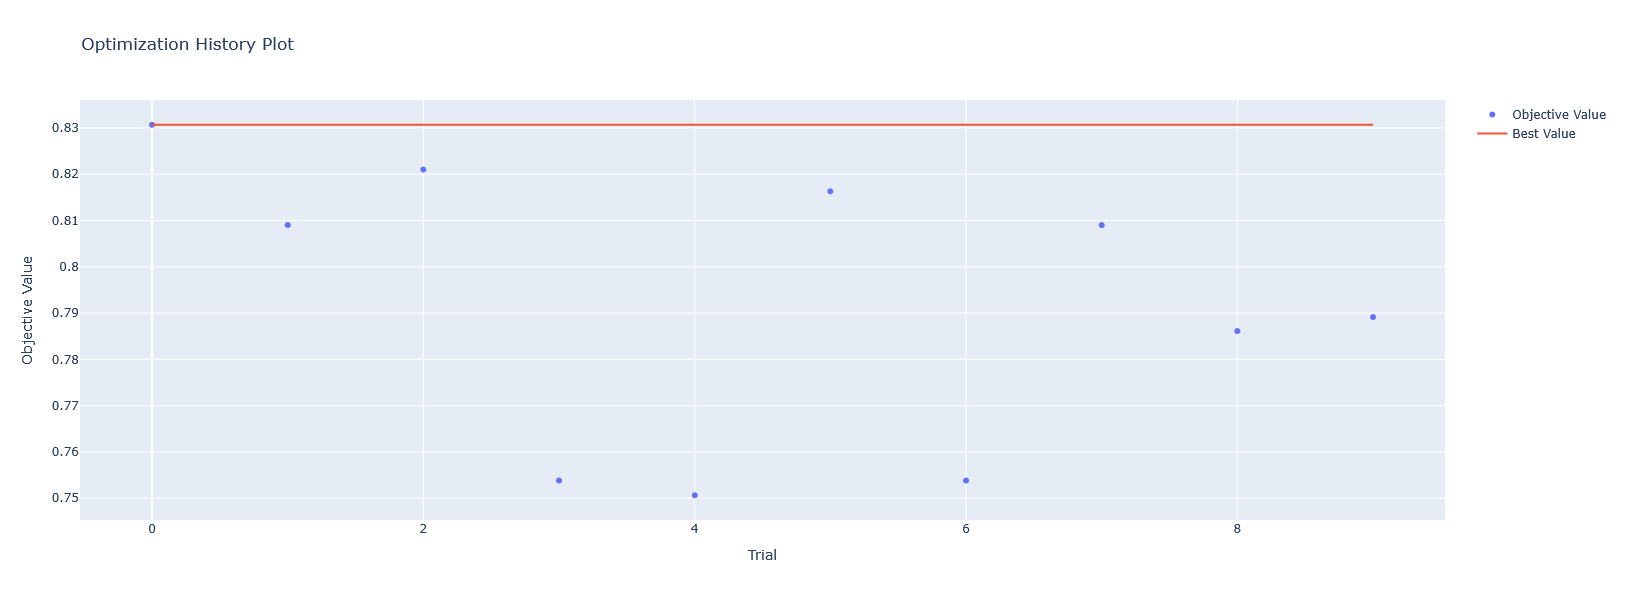

In [39]:
fig = optuna.visualization.plot_optimization_history(study)
fig.update_layout(width=800, height=600)
fig.show()

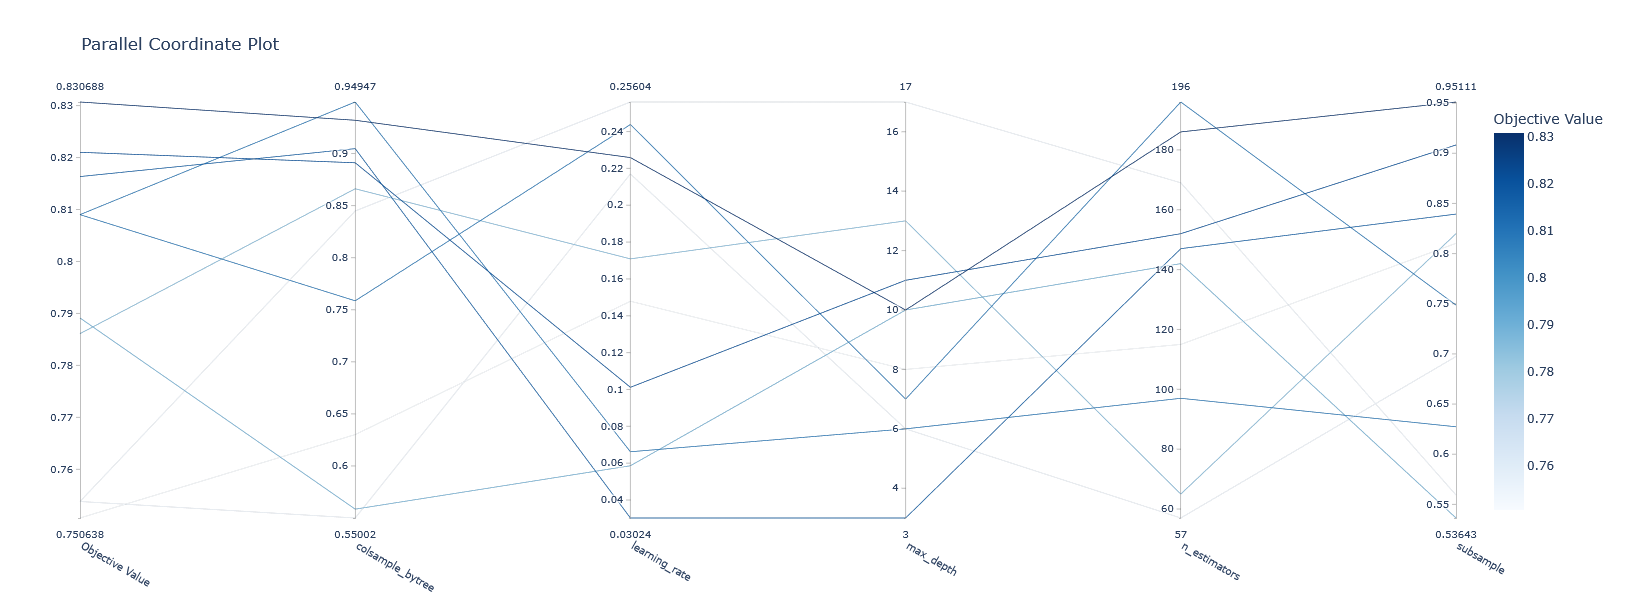

In [40]:
fig = optuna.visualization.plot_parallel_coordinate(study)
fig.update_layout(width=800, height=600)
fig.show()

In [41]:
if plot_param_importances:
    fig = optuna.visualization.plot_param_importances(study)
    fig.update_layout(width=800, height=600)
    fig.show()

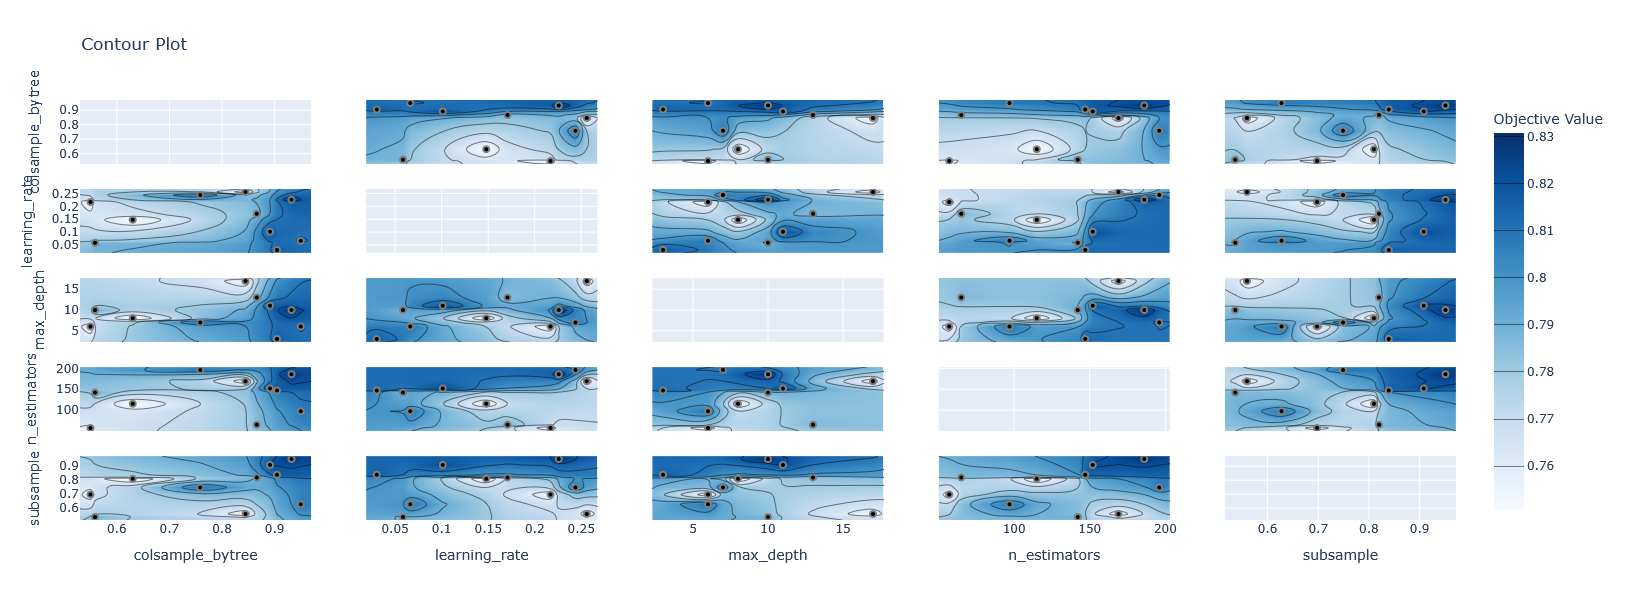

In [42]:
fig = optuna.visualization.plot_contour(study)
fig.update_layout(width=800, height=600)
fig.show()

In [43]:
best_model_params = study.best_trial.params

# STEP 5: EXTRAPOLATION & GENERALIZATION

In [44]:
if n_classes == 3: # dummy dataset
    df_full = pd.read_parquet('input/dummy.parquet')
else:
    df_full = pd.read_parquet(f'input/CICIoT2023_{n_classes}.parquet')

df_full['label'].replace(to_replace=label_to_index, inplace=True)

In [45]:
X_full = df_full.drop('label', axis=1)

print(type(X_full))
print(X_full.shape)
print(X_full.dtypes)

<class 'pandas.core.frame.DataFrame'>
(28000, 10)
x0    float64
x1    float64
x2    float64
x3    float64
x4    float64
x5    float64
x6    float64
x7    float64
x8    float64
x9    float64
dtype: object


In [46]:
y_full = df_full['label']

print(type(y_full))
print(y_full.shape)
print(y_full.dtype)
print(y_full.nunique())

<class 'pandas.core.series.Series'>
(28000,)
int64
3


In [47]:
# Split into 80% training and 20% test
X_full_train, X_full_test, y_full_train, y_full_test = train_test_split(
    X_full, y_full, test_size=0.2, random_state=random_state, stratify=y_full
)

# Verify the sizes of the splits
print(f'Training   : {len(X_full_train)}\t({(100.0 * len(X_full_train) / len(X_full)):.2f}) %\t{sorted(y_full_train.unique())}')
print(f'Test       : {len(X_full_test)}\t({(100.0 * len(X_full_test) / len(X_full)):.2f}) %\t{sorted(y_full_test.unique())}')

Training   : 22400	(80.00) %	[np.int64(0), np.int64(1), np.int64(2)]
Test       : 5600	(20.00) %	[np.int64(0), np.int64(1), np.int64(2)]


In [48]:
assert sorted(y_full_train.unique()) == sorted(y_full_test.unique())

### Baseline

In [49]:
%%time
model = build_classifier()
model.fit(X_full_train, y_full_train)
y_full_pred = model.predict(X_full_test)

CPU times: total: 7.02 s
Wall time: 382 ms


In [50]:
process_metrics(y_full_test, y_full_pred)

OrderedDict([   ('Accuracy', 0.9507142857142857),
                ('Precision (Macro)', np.float64(0.9391295668536236)),
                ('Precision (Micro)', np.float64(0.9507142857142857)),
                ('Precision (Weighted)', np.float64(0.9500776725399237)),
                ('Recall (Macro)', np.float64(0.9201041666666666)),
                ('Recall (Micro)', np.float64(0.9507142857142857)),
                ('Recall (Weighted)', np.float64(0.9507142857142857)),
                ('F1 (Macro)', np.float64(0.9289217890685912)),
                ('F1 (Micro)', np.float64(0.9507142857142857)),
                ('F1 (Weighted)', np.float64(0.9500607589869932))])


In [51]:
process_classification_report(y_full_test, y_full_pred)

              precision    recall  f1-score   support

           0   0.963179  0.980938  0.971977      3200
           1   0.943618  0.951875  0.947729      1600
           2   0.910591  0.827500  0.867060       800

    accuracy                       0.950714      5600
   macro avg   0.939130  0.920104  0.928922      5600
weighted avg   0.950078  0.950714  0.950061      5600



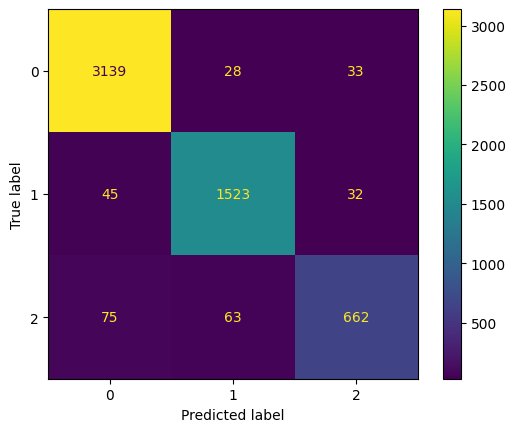

In [52]:
process_confusion_matrix(y_full_test, y_full_pred)

### Optimized

In [53]:
import os
import tempfile

def get_model_size(model):
    with tempfile.NamedTemporaryFile(delete=False, suffix=".ubj") as temp_model:
        model_path = temp_model.name
    if model_name in ['lgbm', 'lightgbm']:
        model.booster_.save_model(model_path)
    elif model_name in ['xgb', 'xgboost', 'xgbrf', 'xgboostrf']:
        model.save_model(model_path)
    model_size_mb = os.path.getsize(model_path) / (1024 * 1024)
    os.remove(model_path)
    return round(model_size_mb, 2)

In [54]:
import psutil
import time
import tracemalloc
from threading import Thread

# Function to monitor CPU usage at high frequency
def monitor_cpu(process, cpu_list, sampling_rate=1e-6):  # High-frequency sampling (1µs)
    while running:
        cpu_list.append(process.cpu_percent(interval=None))
        time.sleep(sampling_rate)  # Sleep briefly to avoid excessive overhead

# Get the current process
process = psutil.Process()
cpu_usage_fit = []
cpu_usage_pred = []

In [55]:
# redo preprocessing
best_preprocessor.fit(X_full_train)
X_full_train = pd.DataFrame(best_preprocessor.transform(X_full_train.copy()), columns=X_full_train.columns)
X_full_test = pd.DataFrame(best_preprocessor.transform(X_full_test.copy()), columns=X_full_test.columns)

# redo feature selection
X_full_train = X_full_train[best_selected_features]
X_full_test = X_full_test[best_selected_features]

# redo data balancing
X_full_train, y_full_train = fit_resample(
    X_full_train, y_full_train, best_over_threshold, best_under_threshold
)

# redo classifier building
model = build_classifier(best_model_params)

In [56]:
# Measure Training CPU & Memory Usage ###
running = True
cpu_thread = Thread(target=monitor_cpu, args=(process, cpu_usage_fit))
cpu_thread.start()

# Start precise memory tracking
tracemalloc.start()
mem_before_fit = process.memory_info().rss  # Total memory before (in bytes)
cpu_start_fit = process.cpu_times()  # CPU time before

start_time = time.time()
model.fit(X_full_train, y_full_train)
train_time = time.time() - start_time

cpu_end_fit = process.cpu_times()  # CPU time after
mem_after_fit = process.memory_info().rss  # Total memory after (in bytes)
train_mem, _ = tracemalloc.get_traced_memory()  # Additional memory allocated
tracemalloc.stop()

running = False
cpu_thread.join()

In [57]:
# Calculate model size
model_size_mb = get_model_size(model)

In [58]:
# Measure Prediction CPU & Memory Usage ###
running = True
cpu_thread = Thread(target=monitor_cpu, args=(process, cpu_usage_pred))
cpu_thread.start()

tracemalloc.start()
mem_before_pred = process.memory_info().rss
cpu_start_pred = process.cpu_times()

start_time = time.time()
y_full_pred = model.predict(X_full_test)
predict_time = time.time() - start_time

cpu_end_pred = process.cpu_times()
mem_after_pred = process.memory_info().rss
predict_mem, _ = tracemalloc.get_traced_memory()
tracemalloc.stop()

running = False
cpu_thread.join()

In [59]:
# Compute CPU time spent
train_cpu_time = (cpu_end_fit.user + cpu_end_fit.system) - (cpu_start_fit.user + cpu_start_fit.system)
predict_cpu_time = (cpu_end_pred.user + cpu_end_pred.system) - (cpu_start_pred.user + cpu_start_pred.system)

# Compute average and peak CPU usage
train_avg_cpu = sum(cpu_usage_fit) / len(cpu_usage_fit) if cpu_usage_fit else 0
train_peak_cpu = max(cpu_usage_fit) if cpu_usage_fit else 0
predict_avg_cpu = sum(cpu_usage_pred) / len(cpu_usage_pred) if cpu_usage_pred else 0
predict_peak_cpu = max(cpu_usage_pred) if cpu_usage_pred else 0

# Compute memory usage (in MB)
train_mem_mb = train_mem / (1024 * 1024)
predict_mem_mb = predict_mem / (1024 * 1024)
train_total_mem_mb = (mem_after_fit - mem_before_fit) / (1024 * 1024)
predict_total_mem_mb = (mem_after_pred - mem_before_pred) / (1024 * 1024)

In [60]:
# Create a DataFrame to store the results in a table format
results_df = pd.DataFrame({
    "Metric": [
        "Execution Time (sec)",
        "CPU Time (sec)",
        "Peak CPU Usage (%)",
        "Avg CPU Usage (%)",
        "Total Memory (MB)",
        "Allocated Memory (MB)"
    ],
    "Training (fit)": [
        train_time,
        train_cpu_time,
        train_peak_cpu,
        train_avg_cpu,
        train_total_mem_mb,
        train_mem_mb
    ],
    "Prediction (predict)": [
        predict_time,
        predict_cpu_time,
        predict_peak_cpu,
        predict_avg_cpu,
        predict_total_mem_mb,
        predict_mem_mb
    ]
})

# Add model size to the table
results_df.loc[len(results_df)] = ["Model Size (MB)", model_size_mb, model_size_mb]

# Print the table
results_df.round(2)

Metric  Training (fit)  Prediction (predict)
0   Execution Time (sec)            1.33                  0.02
1         CPU Time (sec)           24.66                  0.38
2     Peak CPU Usage (%)         1041.70               1363.00
3      Avg CPU Usage (%)            5.00                 62.57
4      Total Memory (MB)           14.68                  0.13
5  Allocated Memory (MB)            0.07                  0.07
6        Model Size (MB)            5.96                  5.96

In [61]:
process_metrics(y_full_test, y_full_pred)

OrderedDict([   ('Accuracy', 0.8864285714285715),
                ('Precision (Macro)', np.float64(0.8449057288331807)),
                ('Precision (Micro)', np.float64(0.8864285714285715)),
                ('Precision (Weighted)', np.float64(0.8856992906437392)),
                ('Recall (Macro)', np.float64(0.84)),
                ('Recall (Micro)', np.float64(0.8864285714285715)),
                ('Recall (Weighted)', np.float64(0.8864285714285715)),
                ('F1 (Macro)', np.float64(0.8424089168802754)),
                ('F1 (Micro)', np.float64(0.8864285714285715)),
                ('F1 (Weighted)', np.float64(0.8860271304268409))])


In [62]:
process_classification_report(y_full_test, y_full_pred)

              precision    recall  f1-score   support

           0   0.928925  0.939375  0.934121      3200
           1   0.878404  0.866875  0.872601      1600
           2   0.727389  0.713750  0.720505       800

    accuracy                       0.886429      5600
   macro avg   0.844906  0.840000  0.842409      5600
weighted avg   0.885699  0.886429  0.886027      5600



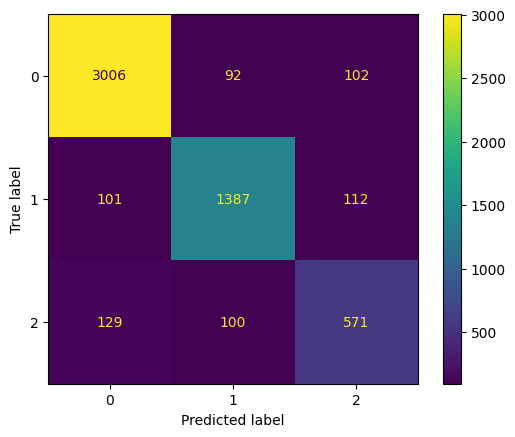

In [63]:
process_confusion_matrix(y_full_test, y_full_pred)